In [1]:
import sys
sys.path.insert(0, "../../")
from classes.calculators.lennardjones import LennardJones
from classes.atom_classes.atom_collection import Atom_Collection
from classes.atom_classes.atom import Atom
from classes.atom_classes.atom_collection_plotter import Atom_Collection_Plotter, Animator
from classes.optimizers.particle_swarm import Particle_swarm
import matplotlib.pyplot as plt
from matplotlib import animation
import numpy as np
import copy
plt.rc('animation', html='jshtml')

{'atoms': [<matplotlib.lines.Line2D at 0x2a89bfa0e90>,
 'unit_cell': None,
 'extra_cells': None}

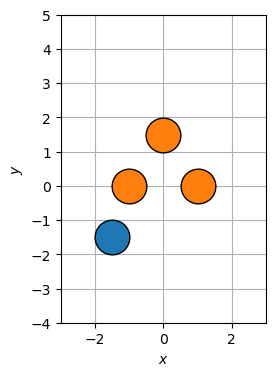

In [54]:
atomlist = []
positions = [np.array([-1.5,-1.5]), np.array([-1.0,0.0]), np.array([1.0,0.0]), np.array([0.0, 1.5])]
colors = ["C0", "C1", "C1", "C1"]
fig, ax = plt.subplots(figsize=(5,4))
ax.set_xlim([-3.0,3.0])
ax.set_ylim([-4.0,5.0])

atom_plotter = Atom_Collection_Plotter(markersize=25)

for position, color in zip(positions, colors):
    atom = Atom(position=position)
    atomlist.append(atom)
ax.grid()

ax.set_aspect("equal")
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$y$")

atom_col = Atom_Collection(atomlist=atomlist)
atom_col.freeze_atoms(indices=[1,2,3])
atom_col.calculator = LennardJones()

E_lim = 3.0
xs = np.linspace(-5.0, 5.0, 400)
ys = np.linspace(-5.0, 5.0, 400)
energies = np.zeros(shape=(len(ys), len(xs)))
for i, x in enumerate(xs):
    for j, y in enumerate(ys):
        atom_col.set_atom_pos(index=0, pos=np.array([x, y]))
        E = atom_col.get_potential_energy()
        if E > E_lim:
            energies[j][i] = E_lim #WE SET LARGE VALUES TO CAP AT E_lim
        else:
            energies[j][i] = E
atom_col.positions[0] = positions[0]


atom_plotter(atom_col=atom_col, ax = ax)

In [37]:
class part_animator(Animator):
    def __init__(self, arrow, default_cols=..., markersize=50, scale_with_mass=False, alpha=1):
        super().__init__(default_cols, markersize, scale_with_mass, alpha)
        self.arrow = arrow

    def plot_atom_col(self, atom_col):
        ax = atom_col.plot_axes
        plot_elems = []
        if atom_col.plot_elems["atoms"] is None:
            for position, frozen in zip(atom_col.positions, atom_col.frozens):
                if frozen == True:
                    pass
                else:
                    p = ax.plot(position[0], position[1], "o", c=self.default_cols[frozen.astype(int)], ms=self.markersize, alpha=self.alpha, markeredgecolor="k")[0]
                    plot_elems.append(p)
        else:
            for position, plot_elem in zip(atom_col.positions, atom_col.plot_elems["atoms"]):
                plot_elem.set_data(position[0], position[1])
            plot_elems = atom_col.plot_elems["atoms"]
        return plot_elems

    def animate(self, i, atom_col, positions, velocities):
        atom_col.set_atom_positions(positions)
        plot_elems = self(atom_col)
        self.arrow.set_data(x=positions[0][0], y=positions[0][1], dx=velocities[0][0],dy=velocities[0][1])
        return plot_elems["atoms"] + [self.arrow]

In [42]:
rattled_atoms = []
for i in range(12):
    rattled_col = copy.deepcopy(atom_col)
    rattled_col.rattle_atoms(rattle_steps=4, delta=1.2)
    #rattled_col.move_atoms(new_pos=0.2*np.ones(shape=rattled_col.positions.shape))
    rattled_col.calculator = LennardJones()
    rattled_atoms.append(rattled_col)
c1 = 0.3
particle_swarmer = Particle_swarm(rattled_atom_cols=rattled_atoms, w=0.8, c1=c1, c2=1.5*c1, gamma=0.8)
particle_swarmer.run(N_max=100, E_crit=-20, track=True)
particles = particle_swarmer.particles

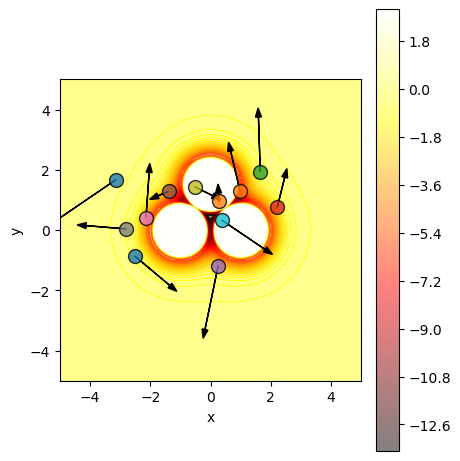

In [43]:
fig, ax = plt.subplots(figsize=(4.5,4.5), layout="constrained")
ax.set_xlim([-5,5])
ax.set_ylim([-5,5])
ax.set_xlabel("x")
ax.set_ylabel("y")


Xi, Yi = np.meshgrid(xs, xs)
cmap = "hot"
ax.contour(Xi, Yi, energies, levels=100, linewidths=0.5, cmap=cmap)
cntr1 = ax.contourf(Xi, Yi, energies, levels=100, cmap=cmap, alpha=0.5)
fig.colorbar(cntr1, ax=ax)
ax.set_aspect("equal")
part_animators = []
atom_cols = []
for i, particle in enumerate(particles):
    atom_col = particle.logged_atom_cols[0]
    vels = particle.logged_velocities[0][0]
    atom_col.reset_plot_axes()
    atom_col_pos = atom_col.positions[0]
    arrow = ax.arrow(atom_col_pos[0], atom_col_pos[1], vels[0], vels[1], head_width=0.2, color="k", zorder=2, lw=1, capstyle="round")
    p_anim = part_animator(arrow=arrow, default_cols=(f"C{i}", "White"), markersize=10, alpha=0.8)
    part_animators.append(p_anim)
    atom_cols.append(atom_col)
    p_anim(atom_col=atom_col, ax=ax)

In [44]:
def update(i, particles, plot_cols, animators):
    tot_plot_elems = []
    for particle, animator, plot_col in zip(particles, animators, plot_cols):
        logged_col = particle.logged_atom_cols[i]
        logged_velocities = particle.logged_velocities[i]
        plot_elems = animator.animate(i, plot_col, logged_col.positions, logged_velocities)
        tot_plot_elems+=plot_elems
    return tot_plot_elems

In [45]:
anim = animation.FuncAnimation(fig,
                               update,
                               frames=100,
                               fargs=(particles, atom_cols, part_animators),
                               interval=100,
                               blit=True)
anim

C:\Users\karst\AppData\Local\Temp\ipykernel_28572\1712580532.py:18: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  plot_elem.set_data(position[0], position[1])
C:\Users\karst\AppData\Local\Temp\ipykernel_28572\1712580532.py:18: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  plot_elem.set_data(position[0], position[1])


In [46]:
writer = animation.PillowWriter(fps=15,
                                 metadata=dict(artist='Me'),
                                 bitrate=1800)
anim.save("pso.gif", writer=writer)

C:\Users\karst\AppData\Local\Temp\ipykernel_28572\1712580532.py:18: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  plot_elem.set_data(position[0], position[1])
